# Logistic Regression

Font: https://www.datacamp.com/community/tutorials/understanding-logistic-regression-python

Import libraries

In [460]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import seaborn as sns
import numpy as np

Creating a df with the disease rates for each city and their respective RISK value (1, if it belongs to a high risk cluster, and 0 otherwise).

In [461]:
cities = pd.read_csv('../../SatScan/muncod_risk_2015_to_2017.csv', index_col=[0])

disease = ""
path = '../../TabNet/Rates/'
all_files = glob.glob(path + "*.csv")
diseases_list = []
all_diseases = cities
for file in all_files:
    file_name = file.split("\\")[1]
    disease = file_name.split("_RATE")[0]
    disease_df = pd.read_csv(path + disease + '_RATE_15_17.csv', sep=',', index_col=0)
    disease_df = disease_df[["RATE", "MUNCOD"]]
    disease_df.rename(columns={"RATE": disease}, inplace=True)

    all_diseases = pd.merge(disease_df, all_diseases, left_on="MUNCOD", right_on="MUNCOD", how="inner")
df = all_diseases.drop('MUNCOD', 1)
df = df.drop('TRAUMATISMO_INTRACRANIANO', 1) # We remove Traumatismo Intracraniano (low p-value on Spearman test)

Fitting a logistic regression line to visualize how the probability of being in a risk cluster changes with the cancer rate label.

The “risk cluster” was plotted on x-axis and “cancer” on the y-axis using regplot( ).

This plot gives us an intuition of how the logistic model fits an ‘S’ curve line and how the probability changes from 0 to 1 with observed values.

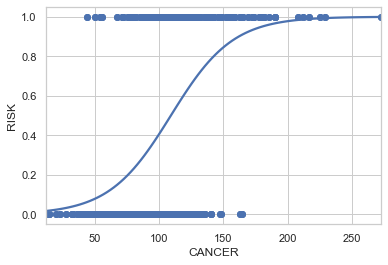

In [462]:
sns.regplot(x="CANCER", y="RISK", data=df,logistic=True, ci=True)
plt.show()

Selecting X (independent variables) and y (dependent binary variable)

In [463]:
X = df.iloc[:, 0:14].values
y = df.iloc[:, -1].values

Splitting the dataset into the Training set and Test set

In [464]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

Feature Scaling

In [465]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

Fitting Logistic Regression to the Training set

In [466]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Predicting the Test set results

In [467]:
y_pred = classifier.predict(X_test)

Making the Confusion Matrix

In [468]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[145,  34],
       [ 32,  85]], dtype=int64)

Text(0.5, 257.44, 'Predicted label')

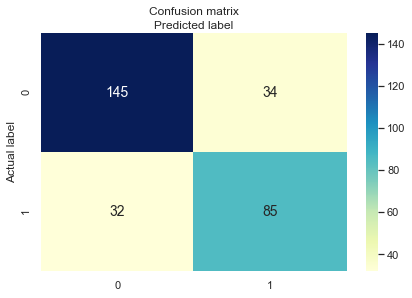

In [469]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Checking Evaluation metrics

In [470]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.777027027027027
Precision: 0.7142857142857143
Recall: 0.7264957264957265


- Accuracy: classification rate of 77%
- Precision: When the model makes a prediction, how often it is correct.
In our case, when the Logistic Regression model predicted cities belong to a high risk cluster, the prediction was correct 71% of the time.
- Recall: If there are cities in a high risk cluster in the test set, the model can identify them 72% of the time.

Plotting the ROC curve

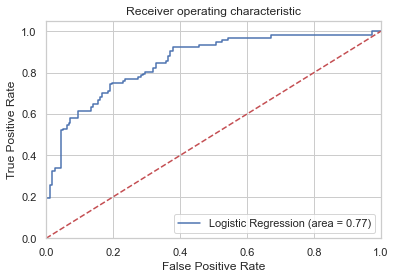

In [471]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

plt.rc("font", size=14)
logit_roc_auc = roc_auc_score(y_test, classifier.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, classifier.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

Selecting most significant features

In [478]:
from sklearn.feature_selection import RFE
selector = RFE(classifier, n_features_to_select=1, step=1)
selector = selector.fit(X_train, y_train)
rank = selector.ranking_

Features: rank of significance

In [481]:
significant_features = []
for i in range(len(df.columns) - 1):
    significant_features.append(str(rank[i]) + " - " + df.columns[i])
significant_features

['14 - OSTEOPOROSE',
 '5 - INSUFICIENCIA_RENAL',
 '6 - INSUFICIENCIA_CARDIACA',
 '11 - HIPERTENSAO_ESSENCIAL',
 '9 - ESCLEROSE_MULTIPLA',
 '3 - EPILEPSIA',
 '4 - ENXAQUECA',
 '2 - DPOC',
 '8 - DORSOPATIAS',
 '7 - DOENCA_DE_PARKINSON',
 '12 - DIABETES_MELLITUS',
 '1 - CANCER',
 '10 - ASMA',
 '13 - AIDS']